### Data Analysis
##### [Hiroyuki Chihara](https://fiomfd.github.io/) (University of the Ryukyus, Okinawa Island, Japan)

1. Public data and visualization
2. Central limit theorem

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
import math
import numpy as np
import csv
import pprint
import pandas as pd
import requests
import io
from ipywidgets import interact, FloatSlider
from scipy.special import gammaln

### 1. Public data and visualization

Let $\vec{x}=\bigl[x[1],\dotsc,x[N]\bigl]^T\in\mathbb{R}^N$ be an $N$-dimensional real column vector. This can describes data such as $x[i]$ means the highest temperature of the $i$-th day for $i=1,\dotsc,N$. One can exploit some information such as the average $m$ and the variance $\sigma^2$:

$m:=\dfrac{1}{N}\displaystyle\sum_{i=1}^Nx[i],
\quad
\sigma^2:=\dfrac{1}{N}\displaystyle\sum_{i=1}^N(x[i]-m)^2.$

In what follows Julia downloads open data, and visualizes information taking averages, maximums and minimums. More concretely Julia downloads 
- the daily maximum tenperature
- the daily minimum tenpereture
- the daily mean tenperature 
of 1884-present at the Hong Kong Observatory. The starting dates of  the theree data are not same, and so we make use of data of 140 years of 1885-2024. The Hong Kong Observatory dataset has no daily temperature records from 1 Jan 1940 to 31 Dec 1946, due to the disruption of WWII and the Japanese occupation. This 7-year gap means that analyses requiring continuous daily data over multiple years will be affected if these years are included. To ensure consistency, we restrict the analysis period to 1 Jan 1947 – 31 Dec 2024.

In [5]:
urlmax = 'https://data.weather.gov.hk/weatherAPI/opendata/opendata.php?dataType=CLMMAXT&rformat=csv&station=HKO'
namemax = 'HK_Maximun_Temperature.csv'

r = requests.get(urlmax)
r.raise_for_status()   
with open(namemax, "wb") as f:
    f.write(r.content)
Amax = pd.read_csv(namemax, encoding="utf-8-sig", sep=None, skiprows=2, skipfooter=3, usecols=[0, 1, 2, 3], engine="python")

Amax.rename(columns={
    "年/Year": "Year",
    "月/Month": "Month",
    "日/Day": "Day",
    "數值/Value": "Maximum",
    "數據完整性/data Completeness": "Completeness"
}, inplace=True)

urlmean = 'https://data.weather.gov.hk/weatherAPI/opendata/opendata.php?dataType=CLMTEMP&rformat=csv&station=HKO'
namemean = 'HK_Mean_Temperature.csv'

r = requests.get(urlmean)
r.raise_for_status()   
with open(namemean, "wb") as f:
    f.write(r.content)
Amean = pd.read_csv(namemean, encoding="utf-8-sig", sep=None, skiprows=2, skipfooter=3, usecols=[0,1,2,3], engine="python")

Amean.rename(columns={
    "年/Year": "Year",
    "月/Month": "Month",
    "日/Day": "Day",
    "數值/Value": "Average",
    "數據完整性/data Completeness": "Completeness"
}, inplace=True)

urlmin = 'https://data.weather.gov.hk/weatherAPI/opendata/opendata.php?dataType=CLMMINT&rformat=csv&station=HKO'
namemin = 'HK_Minimun_Temperature.csv'

r = requests.get(urlmin)
r.raise_for_status()   
with open(namemin, "wb") as f:
    f.write(r.content)
Amin = pd.read_csv(namemin, encoding="utf-8-sig", sep=None, skiprows=2, skipfooter=3, usecols=[0,1,2,3], engine="python")

Amin.rename(columns={
    "年/Year": "Year",
    "月/Month": "Month",
    "日/Day": "Day",
    "數值/Value": "Minimum",
    "數據完整性/data Completeness": "Completeness"
}, inplace=True)

Amax_1885 = Amax[Amax["Year"] >= 1885]
Amean_1885 = Amean[Amean["Year"] >= 1885]
Amin_1885  = Amin[Amin["Year"] >= 1885]
A_1885 = Amax_1885.merge(Amean_1885[["Year", "Month", "Day", "Average"]], on=["Year", "Month", "Day"])
A_1885 = A_1885.merge(Amin_1885[["Year", "Month", "Day", "Minimum"]], on=["Year", "Month", "Day"])
A_1947_2024 = A_1885[(A_1885["Year"] >= 1947) & (A_1885["Year"] <= 2024)]
A_1947_2024 = A_1947_2024.copy()

print(A_1885);

       Year  Month  Day Maximum Average Minimum
0      1885      1    1    17.8    15.3    13.9
1      1885      1    2    20.5    16.7    14.2
2      1885      1    3    16.6    15.4    14.8
3      1885      1    4    18.6    16.1    14.6
4      1885      1    5    20.8    17.5    15.1
...     ...    ...  ...     ...     ...     ...
48785  2025      7   27    33.1    30.4    28.8
48786  2025      7   28    32.8    30.1    28.3
48787  2025      7   29    29.1    27.8    25.8
48788  2025      7   30    32.6    29.8    28.5
48789  2025      7   31    31.8    29.9    28.2

[48790 rows x 6 columns]


Python computes the annual maximum, average, and minmum temperatures, and shows the line graphs. One can see that the annual maximum, average and minimum temperatures have been increasing year and year. 

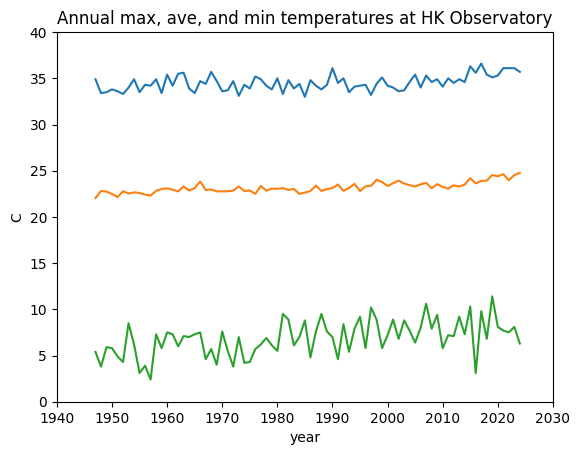

In [6]:
numcols = ["Maximum", "Average", "Minimum"]
for c in numcols:
    A_1947_2024[c] = (
        A_1947_2024[c]
        .astype(str)
        .str.replace(r"[^\d\.\-]", "", regex=True) 
        .replace({"": None})                       
        .pipe(pd.to_numeric, errors="coerce")      
    );

Y = A_1947_2024.groupby("Year").agg(
    Ymax=("Maximum", "max"),
    Yave=("Average", "mean"),
    Ymin=("Minimum", "min")
)

plt.plot(Y)
plt.title("Annual max, ave, and min temperatures at HK Observatory");
plt.xlim([1940,2030]);
plt.ylim([0,40]);
plt.xlabel("year");
plt.ylabel("C");

Moreover, Python computes the monthy maximum, average, and minmum temperatures, and shows the line graphs in each year. Choose the year using the slider. 

In [7]:
M = A_1947_2024.groupby(["Year","Month"]).agg(
    Mmax=("Maximum", "max"),
    Mave=("Average", "mean"),
    Mmin=("Minimum", "min")
);

def hktemp(year=1947):
    plt.title("Monthly max, ave, and min temperatures at HK Observatory")
    plt.plot(M.loc[year])
    plt.ylim([0,40])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    plt.yticks([0,5,10,15,20,25,30,35,40])
    plt.xlabel("month");
    plt.ylabel("C");
    plt.grid(False)
    plt.show()
interact(hktemp,year=(1947, 2024));

interactive(children=(IntSlider(value=1947, description='year', max=2024, min=1947), Output()), _dom_classes=(…

### 2. Central limit theorem for the binomial distribution $B(n,p)$
Let $n$ be a positive integer, and let $p$ be a constant satisfying $0 < p < 1$. 
Denote by $B(n,p)$ the the binomial distribution of $n$ iid experiments $X_1,\dotsc,X_n$ with probability $p$, that is, a discrete probability distribution on $\{0,1,\dotsc,n\}$ such that 

$\operatorname{P}(S_n=k)=\dfrac{n!}{k!(n-k)!}p^k(1-p)^{n-k}, 
\quad
k=0,1,\dotsc,n,$

where $S_n:=X_1+\dotsb+X_n$.

It is well-known that for any $a,b\in\mathbb{R}$ with $a<b$, 

$\operatorname{P}
\left(
a \leqq \dfrac{S_n-pn}{\sqrt{np(1-p)}} \leqq b
\right)
\rightarrow
\dfrac{1}{\sqrt{2\pi}}
\displaystyle\int_a^be^{-x^2/2}dx
\quad
(n \rightarrow \infty),$

which is a typical example of the central limit theorem. We now observe this phenomenon for $p=0.1,\dotsc,0.9$. 

In [8]:
def central_limit(p=0.5,n=1):
    x = np.linspace(-3, 3, 1201)  
    f = np.exp(-x**2/2)/math.sqrt(2*math.pi)

    sigma = np.sqrt(n * p * (1 - p))
    off   = max(100, n)
    z2 = np.zeros(n + 2*off, dtype=float)
    l = np.arange(n + 1, dtype=int)
    logpmf = (
        gammaln(n + 1) - gammaln(l + 1) - gammaln(n - l + 1)
        + l * np.log(p) + (n - l) * np.log1p(-p)
        + np.log(sigma)
    )
    z2[off + l] = np.exp(logpmf)
    z1  = np.zeros(len(x), dtype=float)
    c1  = (len(x) - 1) // 2            
    idx = np.arange(c1)                     
    Lr = np.floor(n*p + (idx/200.0)*sigma).astype(int)
    Ll = np.floor(n*p - (idx/200.0)*sigma).astype(int)    
    right_idx = c1 + np.arange(1, c1 + 1)
    left_idx  = c1 - np.arange(1, c1 + 1)   
    z1[right_idx] = z2[off + 1 + Lr]
    z1[left_idx]  = z2[off + Ll]    
    assert not (np.isnan(z2).any() or np.isnan(z1).any())

    plt.title("B(n,p) --> N(0,1)")
    plt.plot(x, f, label="N(0,1)")
    plt.fill_between(x, z1, step="mid", alpha=0.5, color="C1")
    plt.step(x, z1, where='post', label="B(n,p)")
    plt.xlim(-3, 3)
    plt.ylim(0, 0.45)
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([0,1/math.sqrt(2*math.pi)],[0,"1/√2π"])
    plt.grid(False)
    plt.legend()
    plt.show()

interact(central_limit, p=(0.1, 0.9, 0.1), n=(1, 2400));

interactive(children=(FloatSlider(value=0.5, description='p', max=0.9, min=0.1), IntSlider(value=1, descriptio…